In [63]:
#

from langchain_community.chat_models import ChatOllama
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field
from typing import TypedDict
import operator
import json


In [64]:
# Create Ollama LLaMA model
llm = ChatOllama(
    model="llama3.2:1b",  # <-- or "llama3", or any valid name from `ollama list`
    base_url="http://localhost:11434"
)

In [ ]:
class EssayAnalysisInput(BaseModel):
    feedback : str = Field(..., description="Feedback on the essay")
    score : int = Field(..., description="Score given to the essay", ge=0, le=10)
    


In [66]:
essay_text = """
The impact of climate change on agriculture is profound. Rising temperatures, 
irregular rainfall patterns, and extreme weather events disrupt crop yields. 
Farmers face challenges adapting to these changes, which threatens food security globally.
"""

In [67]:
# State
class GraphState(TypedDict):
    essay: str
    content_analysis: dict
    research_analysis: dict
    grammar_analysis: dict
    final_result: dict


In [68]:
def run_analysis(essay: str, task: str):
    prompt = f"""
You are performing '{task}' on the given essay. 
Return ONLY a JSON object with:
- feedback (string)
- score (integer 0–10)

Essay:
{essay}
"""
    resp = llm.invoke(prompt)
    try:
        parsed = json.loads(resp.content)
        validated = EssayAnalysisOutput.parse_obj(parsed)
        return validated.dict()
    except Exception as e:
        return {"feedback": f"Error parsing output: {str(e)}", "score": 0}


In [69]:
def content_node(state: GraphState):
    state["content_analysis"] = run_analysis(state["essay"], "Content Analysis")
    return state

def research_node(state: GraphState):
    state["research_analysis"] = run_analysis(state["essay"], "Depth of Research Analysis")
    return state

def grammar_node(state: GraphState):
    state["grammar_analysis"] = run_analysis(state["essay"], "Grammar and Structure Analysis")
    return state

In [70]:
def combine_results(state: GraphState):
    all_feedback = []
    all_scores = []
    for key in ["content_analysis", "research_analysis", "grammar_analysis"]:
        result = state.get(key, {})
        all_feedback.append(f"{key}: {result.get('feedback')}")
        all_scores.append(result.get("score", 0))
    avg_score = round(sum(all_scores) / len(all_scores), 2)
    return {
        "final_result": {
            "combined_feedback": "\n".join(all_feedback),
            "average_score": avg_score
        }
    }

In [71]:
workflow = StateGraph(GraphState)
workflow.add_node("content", content_node)
workflow.add_node("research", research_node)
workflow.add_node("grammar", grammar_node)
workflow.add_node("combine", combine_results)

workflow.add_edge(START, "content")
workflow.add_edge(START, "research")
workflow.add_edge(START, "grammar")

workflow.add_edge("content", "combine")
workflow.add_edge("research", "combine")
workflow.add_edge("grammar", "combine")

workflow.add_edge("combine", END)

app = workflow.compile()


### Essay Analysis parallel workflow

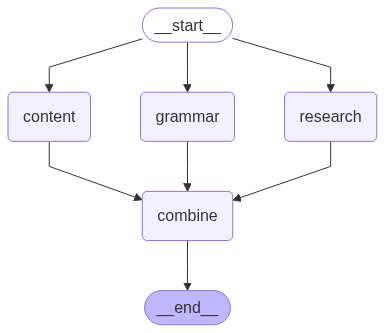

In [77]:
from IPython.display import display, Markdown, Image

display(Markdown("### Essay Analysis parallel workflow"))

# Compile the graph
compiled_graph = workflow.compile()

# Render Mermaid PNG
Image(compiled_graph.get_graph().draw_mermaid_png())


In [76]:
final_state = app.invoke({"essay": essay_text})



C:\Users\Hashim Awan\AppData\Local\Temp\ipykernel_14476\3229248056.py:46: PydanticDeprecatedSince20: The `parse_obj` method is deprecated; use `model_validate` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  validated = EssayAnalysisOutput.parse_obj(parsed)
C:\Users\Hashim Awan\AppData\Local\Temp\ipykernel_14476\3229248056.py:47: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  return validated.dict()


In [78]:
print("=== FINAL FEEDBACK ===")
print(final_state["final_result"]["combined_feedback"])
print("\nAverage Score:", final_state["final_result"]["average_score"])

=== FINAL FEEDBACK ===
content_analysis: This introduction effectively sets up the topic of climate change's impact on agriculture.
research_analysis: The provided essay provides a good overview of the impact of climate change on agriculture, but lacks depth in its analysis.
grammar_analysis: The given essay provides a general overview of the impact of climate change on agriculture but lacks specific details and supporting evidence.

Average Score: 5.33


In [ ]:
workflow